In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-11-25 04:31:49.282417: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 04:31:49.328533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 04:31:50.080795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-25 04:31:51.290773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20169 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capab

In [2]:
import pandas as pd
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# .npy 파일 경로
x_train_path = 'x_train.npy'
y_train_path = 'y_train.npy'
x_val_path = 'x_val.npy'
y_val_path = 'y_val.npy'

# 데이터 불러오기
x_train = np.load(x_train_path)  # 훈련 이미지 데이터
y_train = np.load(y_train_path)  # 훈련 레이블 데이터
x_val = np.load(x_val_path)      # 검증 이미지 데이터
y_val = np.load(y_val_path)      # 검증 레이블 데이터

# 데이터 확인 (첫 번째 샘플 출력 예시)
print("훈련 이미지 데이터 크기:", x_train.shape)
print("훈련 레이블 데이터 크기:", y_train.shape)
print("검증 이미지 데이터 크기:", x_val.shape)
print("검증 레이블 데이터 크기:", y_val.shape)

훈련 이미지 데이터 크기: (737, 512, 512)
훈련 레이블 데이터 크기: (737, 512, 512, 2)
검증 이미지 데이터 크기: (185, 512, 512)
검증 레이블 데이터 크기: (185, 512, 512, 2)


In [4]:
def plot_accuracy_loss(history):
    """
    훈련 및 검증 정확도와 손실을 시각화합니다.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    """
    plt.figure(figsize=(10, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

def calculate_f1_score(model, x_val, y_val, batch_size=4):
    """
    F1 점수를 계산하고 출력합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    
    반환값:
    - y_pred: 예측된 레이블.
    - y_true: 실제 레이블.
    """
    y_pred = np.argmax(model.predict(x_val, batch_size=batch_size), axis=-1)
    y_true = np.argmax(y_val, axis=-1)

    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    print(f"F1 점수: {f1:.2f}")

    return y_true, y_pred

def plot_confusion_matrix_with_metrics(y_true, y_pred):
    """
    혼동 행렬을 시각화하고 정밀도, 재현율, F1 점수를 출력합니다.
    
    매개변수:
    - y_true: 실제 레이블.
    - y_pred: 예측된 레이블.
    """
    # Flatten 데이터
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)
    
    # 메트릭 계산 (zero_division=0 설정)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # 메트릭 출력
    print("=== 성능 지표 ===")
    print(f"정밀도(Precision): {precision:.2f}")
    print(f"재현율(Recall): {recall:.2f}")
    
    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_true_vs_pred_images(model, x_val, y_val, num_images=5, batch_size=4):
    """
    실제 이미지, 라벨 이미지 및 예측된 이미지를 나란히 시각화합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - num_images: 시각화할 이미지 수 (기본값: 5).
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    """
    # 예측 생성
    y_pred = model.predict(x_val, batch_size=batch_size)
    
    plt.figure(figsize=(25, 3 * num_images))
    for i in range(num_images):
        # 실제 입력 이미지
        plt.subplot(num_images, 5, 5 * i + 1)
        plt.imshow(x_val[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # 실제 라벨 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 2)
        plt.imshow(y_val[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Label Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 3)
        plt.imshow(np.argmax(y_val[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Original Label (Argmax)')
        plt.axis('off')
        
        # 예측된 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 4)
        plt.imshow(y_pred[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Predicted Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 5)
        plt.imshow(np.argmax(y_pred[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Predicted Label (Argmax)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def main_display_result(history, model, x_val, y_val, batch_size=4, num_images=5):
    """
    전체 워크플로우 실행: 정확도/손실 그래프 시각화, F1 점수 계산, 혼동 행렬 및 메트릭 출력, 실제/예측 이미지 비교.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    - num_images: 시각화할 이미지 수 (기본값: 5).
    """
    # 훈련 및 검증 정확도/손실 그래프 시각화
    plot_accuracy_loss(history)
    
    # F1 점수 계산 및 예측값 반환
    y_true, y_pred = calculate_f1_score(model, x_val, y_val, batch_size=batch_size)
    
    # 혼동 행렬 및 메트릭 출력
    plot_confusion_matrix_with_metrics(y_true, y_pred)
    
    # 실제 이미지와 예측된 이미지 비교 시각화
    plot_true_vs_pred_images(model, x_val, y_val, num_images=num_images, batch_size=batch_size)

In [5]:
# U-Net 모델 정의
def unet_model(input_shape, num_classes=2):
    """
    U-Net 모델 정의 함수.
    
    매개변수:
    - input_shape: 입력 이미지 형태 (높이, 너비, 채널).
    - num_classes: 출력 채널 수. 기본값은 2 (배경과 객체).

    반환값:
    - Keras 모델 객체.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4 = concatenate([u4, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u2 = concatenate([u2, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u1 = concatenate([u1, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # 출력층
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # num_classes에 따라 출력 채널 설정

    # 모델 정의
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [6]:
# Dice 손실 함수 정의
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice 손실 함수.
    Dice 계수를 기반으로 작은 객체와 클래스 불균형을 다루기 위해 사용.
    
    매개변수:
    - y_true: 실제 값 (ground truth), shape=(batch, height, width, num_classes)
    - y_pred: 예측 값 (predictions), shape=(batch, height, width, num_classes)
    - smooth: 0으로 나누는 오류를 방지하기 위한 작은 값 (기본값: 1e-6)
    
    반환값:
    - dice_loss: Dice 손실 값
    """
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    # Dice 계수 계산
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    total = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    dice_coef = (2.0 * intersection + smooth) / (total + smooth)

    # Dice 손실 반환
    return 1.0 - dice_coef

def dice_coef(y_true, y_pred, smooth=1e-6):
    # True positive, false positive, false negative 계산
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    
    # Dice coefficient 계산
    return (2. * intersection + smooth) / (union + smooth)

# 복합 손실 함수 (Binary Crossentropy + Dice Loss)
def combined_loss(y_true, y_pred):
    # y_true와 y_pred의 데이터 타입을 float32로 변환
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    
    # BCE 손실 계산
    bce_loss = K.binary_crossentropy(y_true, y_pred)
    
    # Dice 손실 계산
    dice_loss = 1 - dice_coef(y_true, y_pred)
    
    return K.mean(bce_loss + dice_loss)


# 클래스 가중치 적용 (데이터셋 기반 계산)
def compute_class_weights(y_train):
    """
    클래스 가중치를 계산합니다. 불균형한 클래스 분포를 처리하기 위해 사용됩니다.
    
    매개변수:
    - y_train: 학습 데이터 레이블 (shape: (batch, height, width, 1))
    
    반환값:
    - class_weights: 클래스별 가중치 딕셔너리
    """
    unique, counts = np.unique(y_train, return_counts=True)
    total_pixels = np.sum(counts)
    class_weights = {cls: total_pixels / (len(unique) * count) for cls, count in zip(unique, counts)}
    return class_weights

# 모델 컴파일 (손실 함수만 적용)
def compile_model_with_weights(model):
    """
    가중치를 고려한 모델 컴파일 함수입니다. 
    손실 함수는 `combined_loss`로 수정되었습니다.
    """
    model.compile(optimizer=Adam(learning_rate=0.01), loss=combined_loss, metrics=['accuracy'])  # 학습률은 0.01로 설정
    return model

# 로그 분석 함수
def analyze_logs(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    print("\n--- 학습 로그 분석 ---\n")
    print(f"최소 학습 손실: {min(train_loss):.4f} (에포크 {train_loss.index(min(train_loss)) + 1})")
    print(f"최소 검증 손실: {min(val_loss):.4f} (에포크 {val_loss.index(min(val_loss)) + 1})")
    print(f"최대 학습 정확도: {max(train_accuracy):.4f} (에포크 {train_accuracy.index(max(train_accuracy)) + 1})")
    print(f"최대 검증 정확도: {max(val_accuracy):.4f} (에포크 {val_accuracy.index(max(val_accuracy)) + 1})")

    if val_loss[-1] > val_loss[val_loss.index(min(val_loss))]:
        print("\n경고: 검증 손실이 다시 증가하고 있습니다. 과적합 가능성을 확인하세요.\n")

    # 손실 그래프 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # 정확도 그래프 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
# 모델 학습 함수 (새로운 손실 함수 사용)
def train_unet_with_weights(
    x_train, y_train, x_val, y_val, batch_size=4, epochs=10, image_size=(512, 512)
):
    # 클래스 가중치 계산
    class_weights = compute_class_weights(y_train)

    # 모델 초기화
    model = unet_model(input_shape=(image_size[0], image_size[1], 1))

    # 컴파일 (새로운 손실 함수 적용)
    model = compile_model_with_weights(model)

    # 모델 학습
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        class_weight=class_weights  # 클래스 가중치 적용
    )

    return model, history

2024-11-25 04:32:03.384942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20169 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


Epoch 1/10


2024-11-25 04:32:12.761298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-25 04:32:12.847360: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-25 04:32:15.379337: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe94639d6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-25 04:32:15.379370: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-11-25 04:32:15.383583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-25 04:32:15.440215: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-25 04:32:15.529034: I ./tensorflow/compiler/jit/device_compil

185/185 [==============================] - 43s 158ms/step - loss: 15425.9258 - accuracy: 0.6993 - val_loss: 0.9304 - val_accuracy: 0.7162
Epoch 2/10
185/185 [==============================] - 29s 158ms/step - loss: 0.9372 - accuracy: 0.7100 - val_loss: 0.9235 - val_accuracy: 0.7162
Epoch 3/10
185/185 [==============================] - 29s 155ms/step - loss: 0.9362 - accuracy: 0.7100 - val_loss: 0.9235 - val_accuracy: 0.7162
Epoch 4/10
185/185 [==============================] - 28s 153ms/step - loss: 0.9362 - accuracy: 0.7100 - val_loss: 0.9234 - val_accuracy: 0.7162
Epoch 5/10
185/185 [==============================] - 26s 143ms/step - loss: 0.9364 - accuracy: 0.7100 - val_loss: 0.9234 - val_accuracy: 0.7162
Epoch 6/10
185/185 [==============================] - 28s 154ms/step - loss: 0.9363 - accuracy: 0.7100 - val_loss: 0.9233 - val_accuracy: 0.7162
Epoch 7/10
185/185 [==============================] - 27s 147ms/step - loss: 0.9362 - accuracy: 0.7100 - val_loss: 0.9239 - val_accuracy:

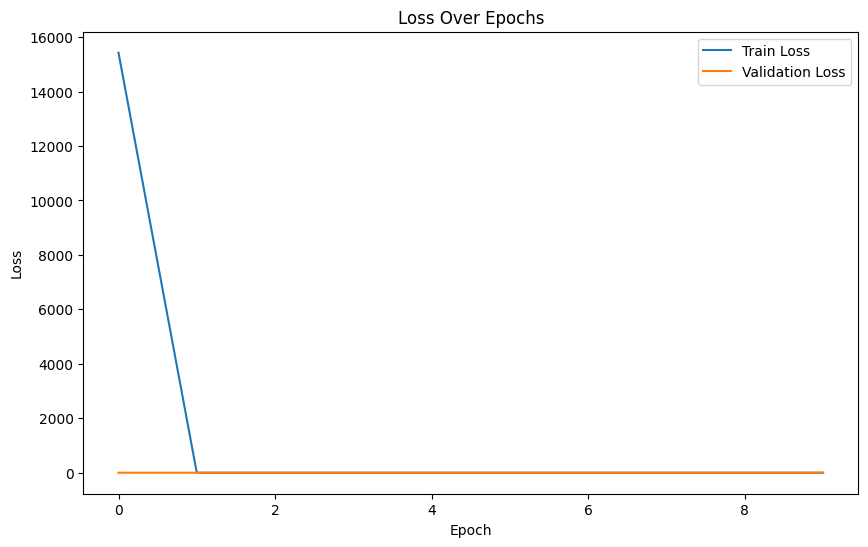

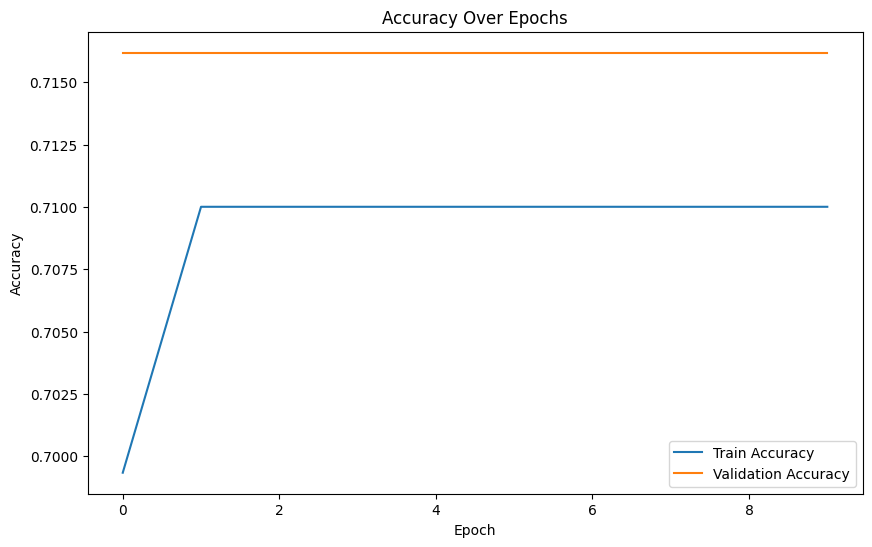

2024-11-25 04:37:18.184565: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-25 04:37:18.184644: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


5/6 [========================>.....] - ETA: 0s - loss: 0.9272 - accuracy: 0.7143

In [ ]:
# 모델 학습 실행
model, history = train_unet_with_weights(
    x_train, y_train, x_val, y_val, batch_size=4, epochs=10
)

# 학습 로그 분석
analyze_logs(history)

# 모델 평가
model.evaluate(x_val, y_val)

In [ ]:
# 모델 저장

model.save('unet_model.h5')  # .h5 파일 형식으로 모델 저장